# Starwarps Example

In [1]:
# Note: this is an example sequence of commands to run in ipython that generates a movie
# from a single night of observation. 
#
# Contact Katie Bouman (klbouman@mit.edu) for any questions 
#
# The methods/techniques used in this, referred to as StarWars, are described in 
# "Reconstructing Video from Interferometric Measurements of Time-Varying Sources" 
# by Katherine L. Bouman, Michael D. Johnson, Adrian V. Dalca, 
# Andrew Chael, Freek Roelofs, Sheperd S. Doeleman, and William T. Freeman

# Note: must import ehtim outside the ehtim directory
# either in parent eht-imaging directory or after installing with setuptools
from __future__ import division
from __future__ import print_function

import numpy as np
import ehtim as eh
from   ehtim.calibrating import self_cal as sc
from ehtim.imaging import patch_prior as pp
import ehtim.image as image

# from ehtim.imaging import starwarps as sw
import starwarps_mod as sw

import matplotlib.pyplot as plt
import sys, os, copy
import scipy
import scipy.optimize as opt
import os
import ehtim.imaging.dynamical_imaging as di


Welcome to eht-imaging! v 1.2.2 



## Set parameters

In [4]:
# data directory
data_dir = '../../starwarps_demo/dynamics_challenge02v2'
# uvfits file -- here we have focused on region 3 which has best coverage
obsname = 'ring+hs_period30_clockwise/region_data/ring+hs_period30_clockwise_regionIII.uvfits'

# data_dir = '../dataset/uvfits'
# obsname = 'SR1_M87_2017_095_hi_hops_netcal_StokesI.uvfits'
# obsname = 'CenA_2017_100_hi_casa_netcal_StokesI.uvfits'


obspath = os.path.join(data_dir, obsname)

# image parameters
# zbl
flux = 2.3
# size
fwhm = 52 * eh.RADPERUAS
fov = 150 * eh.RADPERUAS
NPIX = 30
npixels = NPIX**2
priortype = 'gauss'

# StarWarps optimization parameters
measurement = {'vis':10 } # {'amp':1, 'cphase':1}
variance_img_diff = 1e-7
powerDropoff= 2.0           #covariance smoothness term(larger values result in smoother images)
covfrac = 0.5               #helps to constrain fraction of pixels > 0

warp_method = 'phase'
numLinIters = 5
interiorPriors = True
reassign_apxImgs = False

# parameters associated with EM 
nIters = 30
NHIST = 5000
stop=1e-10
maxit=4000

# directory where to save results
SAVE = True
dirname = '../results'

## Load data

Loading uvfits:  ../dataset/uvfits/CenA_2017_100_hi_casa_netcal_StokesI.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


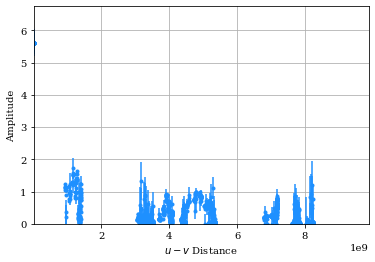

In [5]:
# load in the data
obs = eh.obsdata.load_uvfits(obspath)

obs.add_scans()

# # split the observations based upon the time
# obs_list = sw.splitObs(obs)

# coherently average data
# avg_time = 60
obs = obs.avg_coherent(60, scan_avg=False)

#plot the amplitude of the data
obs.plotall('uvdist', 'amp')

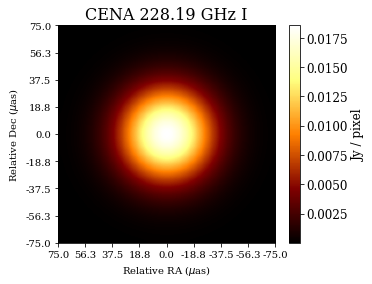

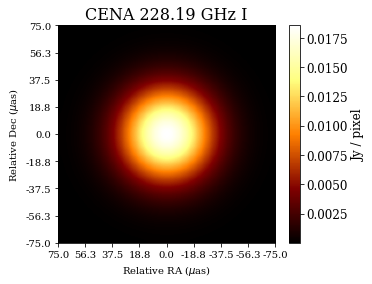

In [6]:
# res = obs.res() # nominal array resolution, 1/longest baseline

emptyprior = eh.image.make_square(obs, NPIX, fov)
if priortype == 'gauss':
    gaussprior = emptyprior.add_gauss(flux, (fwhm, fwhm, 0, 0, 0))
    initimg = gaussprior.copy()
elif priortype == 'disk':
    tophat = emptyprior.add_tophat(flux, fwhm/2.0)
#     tophat = tophat.blur_circ(0.5*res)
    initimg = tophat.copy()
elif priortype == 'ring':
    ringim = emptyprior.add_ring_m1(flux, 0, fwhm/2.0, 0, 10*eh.RADPERUAS)
#     ringim = ringim.blur_circ(0.5*res)
    initimg = ringim.copy()
    
initimg.display()

## Reconstruct movie with no warp field

In [7]:
!which ffmpeg

/home/abao/anaconda3/envs/dpi_torch/bin/ffmpeg


In [8]:
# https://stackoverflow.com/questions/42634997/how-do-i-properly-enable-ffmpeg-for-matplotlib-animation
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

In [9]:
# split the obs into a list of obs at each time
obs_list = di.split_obs(obs)

Splitting Observation File into 125 scans


/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


In [10]:
# # initialize the mean and the image covariance for the prior. 
# # this can be a single image to be the same mean and covariance for each 
# # time, or different for each time by appending an image/matrix for each timestep

# # initialize mean
# meanImg = []
# meanImg.append(initimg)

# # initialize covariance
# imCov = []
# imCov.append( sw.gaussImgCovariance_2(meanImg[0], powerDropoff=2.0, frac=1./2.) )

# # make the covariance matrix that says how much variation there should be between frames in time 
# noiseCov_img = np.eye(npixels)*variance_img_diff

# # initialize the flowbasis and get the initTheta which says how to specify no motion for the specified flow basis
# init_x, init_y, flowbasis_x, flowbasis_y, initTheta = sw.affineMotionBasis_noTranslation(meanImg[0])

# # run StarWarps to find the distribution of the image at each timestep
# expVal_t, expVal_t_t, expVal_tm1_t, loglikelihood, apxImgs = sw.computeSuffStatistics(
#     meanImg, imCov, obs_list, noiseCov_img, initTheta, init_x, init_y, 
#     flowbasis_x, flowbasis_y, initTheta, method=warp_method, measurement=measurement, 
#     interiorPriors=interiorPriors, numLinIters=numLinIters, compute_expVal_tm1_t=False)

In [11]:
# initlize list
imCov = []; meanImg = [];
# set the mean image
meanImg.append(initimg)
# set covariance
imCov.append( sw.gaussImgCovariance_2(meanImg[0], powerDropoff=powerDropoff, frac=covfrac) )
# make the covariance matrix that says how much variation there should be between frames in time
noiseCov_img = np.eye(npixels)*variance_img_diff
# initialize the flowbasis and get the initTheta which says how to specify no motion for the specified flow basis
init_x, init_y, flowbasis_x, flowbasis_y, initTheta = sw.affineMotionBasis_noTranslation(meanImg[0])


In [12]:
# reconstruct a video
frames, expVal_t_t, expVal_tm1_t, loglikelihood, apxImgs = \
    sw.computeSuffStatistics(meanImg, imCov, obs_list, noiseCov_img, initTheta, \
                             init_x, init_y,flowbasis_x, flowbasis_y, initTheta, \
                             method=warp_method, measurement=measurement, \
                             interiorPriors=interiorPriors, numLinIters=numLinIters, \
                             compute_expVal_tm1_t=False)

Backward timestep 0 of 125 total timesteps.....

processing image 124 of 125 ...

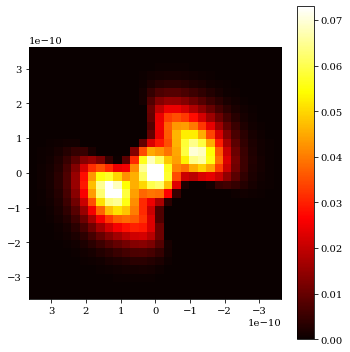

In [13]:
# save out results as a movie
if SAVE:
    # make the directory to save out the results
    try:
        os.stat(dirname)
    except:
        os.mkdir(dirname)
    
    # save out the movie that is generated assuming there is no motion
    sw.movie(frames, out = dirname + '/movie_nomotion.mp4')

In [14]:
# asign the time corresponding to each reconstructed frame
for i in range(len(frames)):
    frames[i].time = obs_list[i].data['time'][0]
    frames[i].mjd  = obs_list[i].mjd

# merge frames together to form a movie
movie = eh.movie.merge_im_list(frames)
movie.reset_interp(interp='linear', bounds_error=False)
obs_movie = eh.selfcal(obs, movie, method='both', ttype='direct', solution_interval=0.0)


Merging 125 frames from MJD 57853 4.44 hr to MJD 57853 10.04 hr
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from movie with direct FT . . . 


/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


Not Using Multiprocessing
Scan 124/125 : [----------------------------- ]99%
self_cal time: 30.063313 s


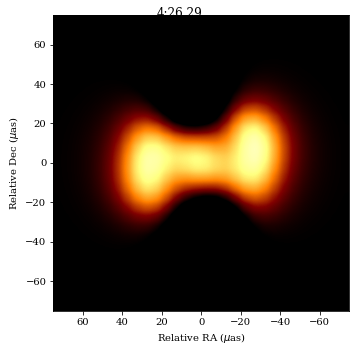

In [15]:
# save movie
movie.save_hdf5('./movie.hdf5')

# export a movie with the frames
di.export_movie(frames, fps=10, out='./movie.mp4')
# os.system('ffmpeg -i movie.mp4 movie.gif')

In [16]:
# save diagnositic pdf
eh.imgsum(movie, obs_movie, obs, 'movie.pdf', outdir='.', title='imgsum', ttype='direct')

displaying the image
displaying the blurred image
blur_FWHM:  25.050581376478934
calculating statistics
Splitting Observation File into 125 times


/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


Splitting Observation File into 125 times
Splitting Observation File into 125 times
Splitting Observation File into 125 times
Splitting Observation File into 125 times
Splitting Observation File into 125 times
Splitting Observation File into 125 times
Splitting Observation File into 125 times
Splitting Observation File into 125 times
Splitting Observation File into 125 times
chi^2 vis: 2.45 35.17
chi^2 amp: 2.68 7.74
chi^2 cphase: 3.49 3.49
chi^2 logcamp: 3.64 3.64
chi^2 camp: 3.64 3.64
calculating cphase statistics
Producing clean visibilities from movie with direct FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Warning!: in add_noise, some SEFDs are <= 0!
NOT recomputing sigmas, which may result in double systematic noise
calculating camp statistics
saving pdf page 1
plotting vis amps
plotting gains
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Produci

/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


Using Multiprocessing with 4 Processes
Scan 125/125 : [------------------------------]100%
self_cal time: 5.392870 s
No Calibration  Data for PV !
No Calibration  Data for SR !


/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ehtim/obsdata.py:556: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


baseline vis amps chisq
saving pdf page 2
plotting amplitudes


/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


saving pdf page 3


/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


saving pdf page 4
saving pdf page 5
saving pdf page 6
plotting closure phases
saving pdf page 7
saving pdf page 8
saving pdf page 9
plotting closure amplitudes
saving pdf page 10
saving pdf page 11
saving pdf page 12
saving pdf page 13


/home/abao/anaconda3/envs/dpi_torch/lib/python3.7/site-packages/ehtim/image.py:3764: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show(block=False)


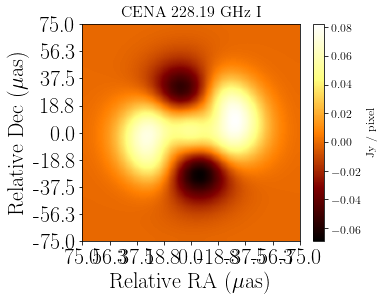

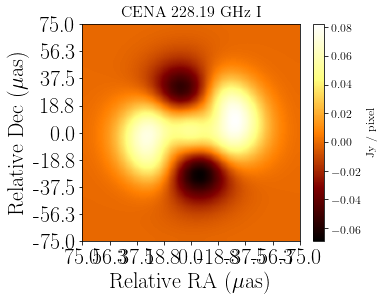

In [17]:
frame_num = 20
movie.get_frame(frame_num).display()

## Learn warp field and reconstruct movie using derived EM-algorithm

In [16]:
# number of motion parameters
nbasis = flowbasis_x.shape[2] 

# set the bounds for the motion parameters
bnds = []
for b in range(0,nbasis):
    bnds.append( (-1.5,1.5) )


# initialize optimization parameters
newTheta = copy.deepcopy(initTheta)
feval = 0.0
optdict = {'maxiter':maxit, 'ftol':stop, 'maxcor':NHIST, 'disp':True} # minimizer params
negll = []
thetas = []
fevals = []

for iter in range(0, nIters+1):

    print('\rIteration %i of %i ...' % (iter, nIters+1) )
    
    # ========== E-step ========== #
    if iter==0 or reassign_apxImgs:
        apxImgs = False

    # solve for the sufficient statistics using the StarWarps approach with the previous value 
    # the warp parameters in newTheta
#     expVal_t, expVal_t_t, expVal_tm1_t, loglikelihood, apxImgs = sw.computeSuffStatistics(
#         meanImg, imCov, obs_list, noiseCov_img, newTheta, init_x, init_y, 
#         flowbasis_x, flowbasis_y, initTheta, method=warp_method, measurement=measurement, 
#         interiorPriors=interiorPriors, numLinIters=numLinIters)
    
    expVal_t, expVal_t_t, expVal_tm1_t, loglikelihood, apxImgs = \
    sw.computeSuffStatistics(meanImg, imCov, obs_list, noiseCov_img, newTheta, \
                             init_x, init_y, flowbasis_x, flowbasis_y, initTheta, \
                             method=warp_method, measurement=measurement, \
                             interiorPriors=interiorPriors, numLinIters=numLinIters)

    # save the negative log likelihood (nll), the value of the warp parameters (thetas) 
    # and the evaluation of the optimization function (feval)
    negll.append(-loglikelihood[2])
    thetas.append(newTheta)
    fevals.append(feval)
    
    # ========== visualize and save results ========== #
    
    if SAVE: 
    
        # make the directory to save out the results
        try:
            os.stat(dirname + '/' + str(iter))
        except:
            os.mkdir(dirname + '/' + str(iter))
    
        # save frames as the mean and the estimated standard deviation of each frame
        stdevImg = meanImg[0].copy()
        for i in range(0,len(obs_list)):
            stdevImg.imvec = np.sqrt(np.diag(expVal_t_t[i]))
            expVal_t[i].save_fits(dirname + '/' + str(iter) + '/mean_' + str(i) + '.fits')
            stdevImg.save_fits(dirname + '/' + str(iter) +  '/stdev_' + str(i) + '.fits')

        # compute the average image
        avgImg = meanImg[0].copy()
        avgImg.imvec = np.mean([im.imvec for im in expVal_t],axis=0)
    
        #save flow diagram
        plt.figure(), sw.plot_Flow(avgImg, thetas[iter], init_x, init_y, flowbasis_x, flowbasis_y, initTheta, step=1)
        plt.savefig(dirname + '/flow_' + str(iter) +  '.pdf')

        #save a movie
        sw.movie(expVal_t, dirname + '/movie_' + str(iter) + '.mp4')

        # save out mat file with the information
        scipy.io.savemat(dirname + '/info_' + str(iter) + '.mat', {'negll':negll, 'thetas':thetas, 'funeval':fevals})
    
    # ========== M-step ========== #
    if iter < nIters:
        result = opt.minimize(sw.expnegloglikelihood, newTheta, args=(expVal_t, expVal_t_t, expVal_tm1_t, meanImg, imCov, obs_list, noiseCov_img, init_x, init_y, flowbasis_x, flowbasis_y, initTheta, warp_method), method='L-BFGS-B', jac=sw.deriv_expnegloglikelihood, bounds=bnds, options=optdict)
        newTheta = result.x
        feval = result.fun


Iteration 0 of 31 ...
Backward timestep 0 of 61 total timesteps....

KeyboardInterrupt: 